# Explore bias-correction

This notebook aims to serve as the record for determining how we go about bias-correcting CMIP6 data with ERA5. 

In [1]:
from pathlib import Path
import xarray as xr
from xclim import sdba
import matplotlib.pyplot as plt
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

/home/kmredilla/miniconda3/envs/dask_env/lib/python3.11/site-packages/xclim/indices/fire/_cffwis.py:217: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/kmredilla/miniconda3/envs/dask_env/lib/python3.11/site-packages/xclim/indices/fire/_cffwis.py:237: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


In [2]:
era5_dir = Path("/center1/CMIP6/kmredilla/era5/daily_regrid/")
cmip6_dir = Path("/beegfs/CMIP6/arctic-cmip6/regrid")
cmip6_tmp_fn = "{var_id}_day_{model}_{scenario}_regrid_{year}0101-{year}1231.nc"

log_dir = "."

In [3]:
ref_var_id = "t2mmin"
ref_fps = list(era5_dir.joinpath(ref_var_id).glob("*.nc"))

var_id = "tasmin"
model = "GFDL-ESM4"

hist_start_year = 1981
hist_end_year = 2014

hist_fps = [
    cmip6_dir.joinpath(
        model,
        "historical",
        "day",
        var_id,
        cmip6_tmp_fn.format(
            var_id=var_id, model=model, scenario="historical", year=year
        ),
    )
    for year in range(hist_start_year, hist_end_year + 1)
]

scenario = "ssp585"
sim_start_year = 2015
sim_end_year = 2100
sim_fps = [
    cmip6_dir.joinpath(
        model,
        scenario,
        "day",
        var_id,
        cmip6_tmp_fn.format(var_id=var_id, model=model, scenario=scenario, year=year),
    )
    for year in range(sim_start_year, sim_end_year + 1)
]

In [4]:
cluster = SLURMCluster(
    cores=8,
    processes=2,
    memory="32GB",
    queue="debug",
    walltime="01:00:00",
    log_directory=log_dir,
    account="cmip6",
    interface="ib0",
)

In [5]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.55.40.4:8787/status,
Dashboard: http://10.55.40.4:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.55.40.4:38661,Workers: 0
Dashboard: http://10.55.40.4:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
cluster.scale(1)

In [7]:
# we are loading these into memory because bias correction can only occur
#  over dimension with chunk size of 1
#  (so we are just circumventing the chunking for now by loading it, it's only ~600MB each for the 35 files)
hist_ds = xr.open_mfdataset(hist_fps)
hist_ds.load()

# convert calendar to noleap to match CMIP6
ref_ds = xr.open_mfdataset(ref_fps).convert_calendar("noleap")
ref_ds.load()

# this one will be a few GBs
sim_ds = xr.open_mfdataset(sim_fps)
sim_ds.load()

<xarray.Dataset>
Dimensions:  (time: 31390, lat: 43, lon: 288)
Coordinates:
    height   float64 2.0
  * time     (time) object 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
  * lat      (lat) float64 50.42 51.36 52.3 53.25 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    tasmin   (time, lat, lon) float32 nan 276.5 275.5 274.6 ... nan nan nan nan
Attributes: (12/47)
    external_variables:     areacella
    history:                File was processed by fremetar (GFDL analog of CM...
    table_id:               day
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    ...                     ...
    tracking_id:            hdl:21.14100/ba9c64d6-d5e3-43a9-92d1-f044ed1e58da
    variable_id:            tasmin
    variant_info:           N/A
    references:             see further_info_url attribute
    variant_label:          r1i1p1f1
    regrid_method:          bilinear

Sample plot check:

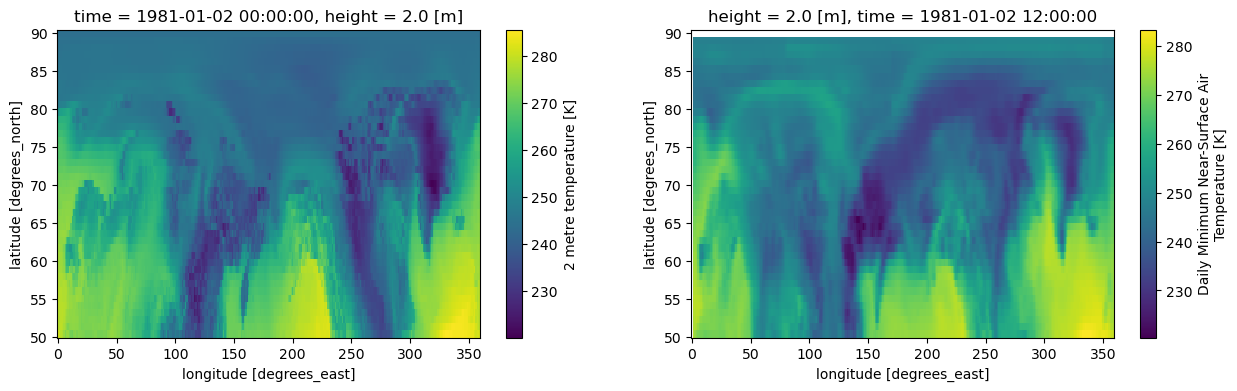

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

ref_ds["t2mmin"].isel(time=1).plot(ax=axes[0])
hist_ds["tasmin"].isel(time=1).plot(ax=axes[1])

Test the bias-correction. Train the quantile mapping object:

In [9]:
ref = ref_ds["t2mmin"]
hist = hist_ds["tasmin"]

QM = sdba.EmpiricalQuantileMapping.train(
    ref, hist, nquantiles=15, group="time", kind="+"
)

And adjust:

In [10]:
sim = sim_ds["tasmin"]
scen = QM.adjust(sim, extrapolation="constant", interp="nearest")

/home/kmredilla/miniconda3/envs/dask_env/lib/python3.11/site-packages/xclim/sdba/utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(


In [11]:
cluster.close()

Do some plotting to evaluate:

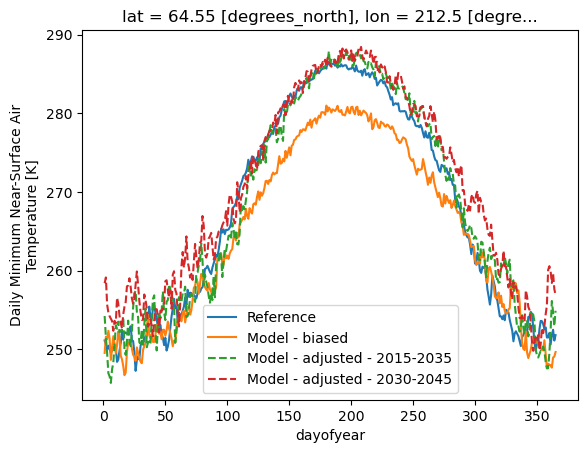

In [27]:
sel_di = {"lon": 213, "lat": 65}
ref.sel(sel_di, method="nearest").groupby("time.dayofyear").mean().plot(
    label="Reference"
)
hist.sel(sel_di, method="nearest").groupby("time.dayofyear").mean().plot(
    label="Model - biased"
)
scen.sel(sel_di, method="nearest").sel(time=slice("2015", "2030")).groupby(
    "time.dayofyear"
).mean().plot(label="Model - adjusted - 2015-2035", linestyle="--")
scen.sel(sel_di, method="nearest").sel(time=slice("2030", "2045")).groupby(
    "time.dayofyear"
).mean().plot(label="Model - adjusted - 2030-2045", linestyle="--")
plt.legend()